# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [25]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('No. of rows     : ', azdias.shape[0], 
      '\nNo. of columns  : ', azdias.shape[1])

No. of rows     :  891221 
No. of columns  :  85


In [26]:
print(azdias.head(5))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                     

In [27]:
print(azdias.describe())

            AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  205378.000000         888340.000000  891221.000000  886367.000000   
mean        1.743410              2.757217       1.522098       3.632838   
std         0.674312              1.009951       0.499512       1.595021   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min    

In [28]:
print(azdias.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [29]:
print("\nFrequency of dtypes: \n", azdias.dtypes.value_counts())


Frequency of dtypes: 
 float64    57
int64      24
object      4
dtype: int64


In [30]:
print(feat_info.head())

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [31]:
# Identify missing or unknown data values and convert them to NaNs.
missing_org = azdias.isnull().sum().sum()

print('Total missing values originally: ', missing_org)


Total missing values originally:  8373929


In [32]:
# Checking
str(feat_info.iloc[57]['missing_or_unknown'].strip('[]').split(sep=','))

"['-1', 'X']"

In [33]:
print(azdias.columns[azdias.dtypes == "object"])

Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')


In [34]:
# if the dtype is object, include quotes for the missing values too inside the list
miss_var0=[]
for i in list(range(feat_info.shape[0])):
    miss_var0.append(str(feat_info.iloc[i]['missing_or_unknown'].strip('[]').split(sep=',')))
    
miss_var = np.where(feat_info['attribute'].isin(azdias.columns[azdias.dtypes == "object"]),
                    miss_var0, feat_info['missing_or_unknown'])

print(miss_var)

['[-1,0]' '[-1,0,9]' '[-1,0]' '[0]' '[-1]' '[-1]' '[-1]' '[-1]' '[-1]'
 '[-1]' '[-1]' '[0]' '[]' '[]' '[-1,0]' '[0]' '[0]' '[0]' '[0]' '[0]' '[0]'
 '[-1,0]' '[-1,0]' '[0]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]'
 '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]'
 '[-1,9]' '[-1]' '[-1]' '[-1,0]' '[-1]' '[-1,9]' '[0]' '[]' '[]' '[-1,0]'
 '[-1]' '[-1,0]' '[-1,0]' '[0]' '[]' '[-1,0]' '[]' '[0]' "['-1']" '[-1]'
 "['-1', 'X']" "['XX']" "['-1', 'XX']" '[-1]' '[-1]' '[-1]' '[-1]' '[-1,0]'
 '[-1,0]' '[-1]' '[-1]' '[-1]' '[]' '[-1,0]' '[]' '[]' '[-1,0]' '[]' '[-1]'
 '[-1]' '[-1]' '[-1]' '[-1,0]' '[-1]' '[-1]' '[-1,9]' '[-1,0]' '[-1,9]']


In [35]:
# replace unknown/missing values with nans
for i in list(range(len(azdias.columns))):
    if len((eval(miss_var[i]))) != 0:
        azdias[azdias.columns[i]]=azdias[azdias.columns[i]].replace(eval(miss_var[i]), np.nan)

In [36]:
# Count number of missing values
missing_new = azdias.isnull().sum().sum()

print('Total missing values after conversion: ', missing_new)

Total missing values after conversion:  8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [37]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_counts = azdias.isnull().sum()
missing_counts 

print("Variables and missing counts:\n")
print(missing_counts.sort_values(ascending=False).head(40))

Variables and missing counts:

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU

In [39]:

missing_percent = azdias.isnull().sum()/len(azdias)*100
missing_percent

print("Variables and missing percent:\n")
print(missing_percent.sort_values(ascending=False))

Variables and missing percent:

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW       

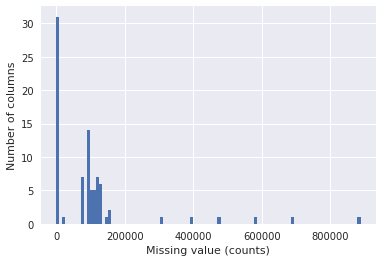

In [40]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_counts, bins=100)
plt.xlabel('Missing value (counts)')
plt.ylabel('Number of columns')
plt.show()


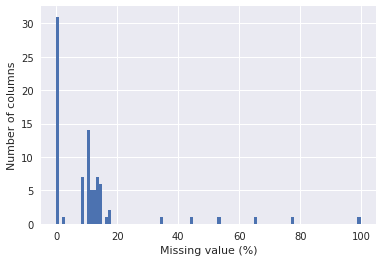

In [41]:
plt.hist(missing_percent, bins=100)
plt.xlabel('Missing value (%)')
plt.ylabel('Number of columns')
plt.show()

In [42]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_gt_20 = list(missing_percent[missing_percent>20].index)
print('Drop columns: ', missing_gt_20)

azdias = azdias.drop(missing_gt_20, axis=1)
print('No. of columns after dropping: ', azdias.shape[1])

Drop columns:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
No. of columns after dropping:  79


#### Discussion 1.1.2: Assess Missing Data in Each Column

The counts and percentages of missing data are given in the preceding cells. Some of the columns were related, due to which a missing value in one of them corresponds to missing values in the remaining columns. Examples of such columns are 'KBA05_xxx' variables like KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, etc. and 'PLZ8_xxx' variables like PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_HHZ, PLZ8_GBZ and PLZ8_BAUMAX. Most of the columns had less than 20% missing data, however there were 6 columns with at least 20% missing data which were AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'. These 6 columns were considered outlier columns and were removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [43]:
# How much data is missing in each row of the dataset?
missing_counts_rows = azdias.isnull().sum(axis=1)
missing_counts_rows 

print("Variables and missing counts:\n")
print(missing_counts_rows.sort_values(ascending=False))


Variables and missing counts:

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64


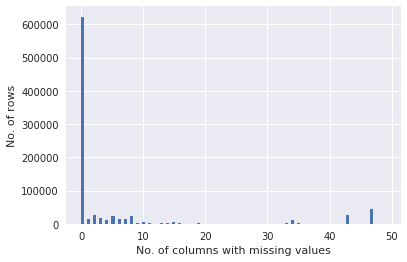

In [44]:
plt.hist(missing_counts_rows, bins=100)
plt.xlabel('No. of columns with missing values')
plt.ylabel('No. of rows')
plt.show()

In [45]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# using 20 as threshold
azdias_gt20 = azdias.loc[missing_counts_rows[missing_counts_rows >20].index,]
print(azdias_gt20.shape)


(93795, 79)


In [46]:
azdias_lte20 = azdias.loc[missing_counts_rows[missing_counts_rows <=20].index,]
print(azdias_lte20.shape)

(797426, 79)


In [47]:
print(azdias_gt20.columns)


Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [48]:
few_miss_vals = azdias.isnull().sum()/len(azdias)*100

print(missing_percent.sort_values(ascending=True).head(10))

ZABEOTYP         0.0
SEMIO_TRADV      0.0
SEMIO_PFLICHT    0.0
SEMIO_KAEM       0.0
SEMIO_DOM        0.0
SEMIO_KRIT       0.0
SEMIO_RAT        0.0
SEMIO_KULT       0.0
SEMIO_ERL        0.0
SEMIO_LUST       0.0
dtype: float64


In [49]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plt_compare(varname):
    plt.subplot(121).set_title('Less than or equal to \n20 missing columns')
    sns.countplot(x=varname, data=azdias_lte20)
    plt.subplot(122).set_title('More than \n20 missing columns')
    sns.countplot(x=varname, data=azdias_gt20)
    plt.tight_layout()
    
    

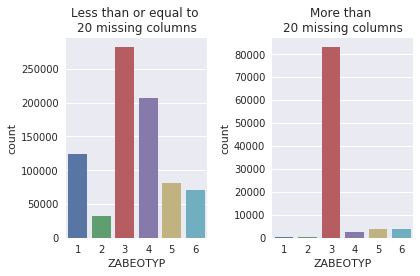

In [50]:
plt_compare('ZABEOTYP')

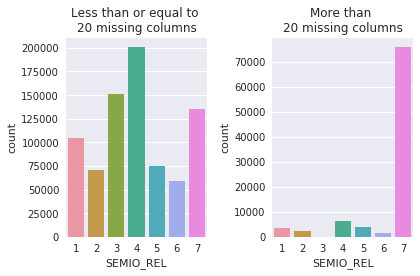

In [51]:
plt_compare('SEMIO_REL')

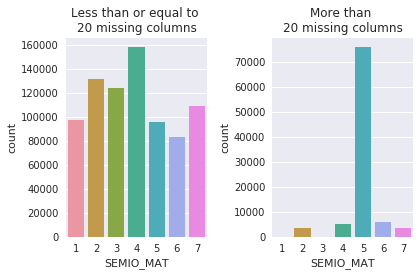

In [52]:
plt_compare('SEMIO_MAT')

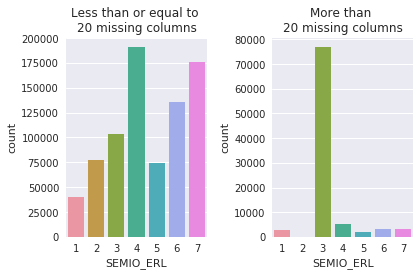

In [53]:
plt_compare('SEMIO_ERL')

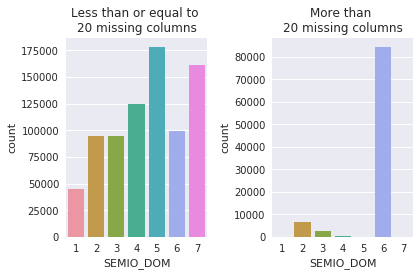

In [54]:
plt_compare('SEMIO_DOM')

#### Discussion 1.1.3: Assess Missing Data in Each Row

The missing counts for rows are given in preceding cells. Most of the rows have at most 20 columns with missing data, thus I divided the data based on 'less than or equal to 20 missing columns' and 'more than 20 missing columns'. Based on the sample columns selected for plots, the distribution for these two datasets looked different. For the columns with more than 20 missing columns, they tended to belong to a single category. For now, I used the subset of data with few or no missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [55]:
# How many features are there of each data type?

feat_info2 = feat_info[~feat_info['attribute'].isin(missing_gt_20)]

print(feat_info2.type.value_counts())

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [56]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_cat = feat_info2[feat_info2['type']=='categorical']
feat_cat


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [57]:
uniq_cat = pd.DataFrame()
for cols in list(feat_cat['attribute']):
    print('Unique values for ',cols, ':')
    print(azdias_lte20[cols].sort_values().unique())
    uniq_vals = azdias_lte20[cols].dropna().sort_values().unique()
    len_uniq = len(uniq_vals)
    uniq_cat = uniq_cat.append({'Vars': cols, 'Vals': len_uniq, 'Uniqvals':uniq_vals}, ignore_index=True)
    print('Total unique values: ', len_uniq)
    print('\n')

Unique values for  ANREDE_KZ :
[1 2]
Total unique values:  2


Unique values for  CJT_GESAMTTYP :
[  1.   2.   3.   4.   5.   6.  nan]
Total unique values:  6


Unique values for  FINANZTYP :
[1 2 3 4 5 6]
Total unique values:  6


Unique values for  GFK_URLAUBERTYP :
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  nan]
Total unique values:  12


Unique values for  GREEN_AVANTGARDE :
[0 1]
Total unique values:  2


Unique values for  LP_FAMILIE_FEIN :
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  nan]
Total unique values:  11


Unique values for  LP_FAMILIE_GROB :
[  1.   2.   3.   4.   5.  nan]
Total unique values:  5


Unique values for  LP_STATUS_FEIN :
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  nan]
Total unique values:  10


Unique values for  LP_STATUS_GROB :
[  1.   2.   3.   4.   5.  nan]
Total unique values:  5


Unique values for  NATIONALITAET_KZ :
[  1.   2.   3.  nan]
Total unique values:  3


Unique values for  SHOPPER_TYP :
[  0.   1.   

In [58]:
# Binary variables
uniq_cat[uniq_cat['Vals']==2]

,Uniqvals,Vals,Vars
0,"[1, 2]",2.0,ANREDE_KZ
4,"[0, 1]",2.0,GREEN_AVANTGARDE
11,"[0.0, 1.0]",2.0,SOHO_KZ
12,"[1.0, 2.0]",2.0,VERS_TYP
15,"[O, W]",2.0,OST_WEST_KZ


In [59]:
# Multi=level variables
uniq_cat[uniq_cat['Vals']!=2]

,Uniqvals,Vals,Vars
1,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",6.0,CJT_GESAMTTYP
2,"[1, 2, 3, 4, 5, 6]",6.0,FINANZTYP
3,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",12.0,GFK_URLAUBERTYP
5,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",11.0,LP_FAMILIE_FEIN
6,"[1.0, 2.0, 3.0, 4.0, 5.0]",5.0,LP_FAMILIE_GROB
7,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",10.0,LP_STATUS_FEIN
8,"[1.0, 2.0, 3.0, 4.0, 5.0]",5.0,LP_STATUS_GROB
9,"[1.0, 2.0, 3.0]",3.0,NATIONALITAET_KZ
10,"[0.0, 1.0, 2.0, 3.0]",4.0,SHOPPER_TYP
13,"[1, 2, 3, 4, 5, 6]",6.0,ZABEOTYP


In [60]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_lte20['OST_WEST_KZ'] = np.where(azdias_lte20['OST_WEST_KZ']=='O', 0, 1)


In [61]:
print(azdias_lte20['OST_WEST_KZ'].value_counts())

1    628987
0    168439
Name: OST_WEST_KZ, dtype: int64


In [62]:
azdias_lte20 = azdias_lte20.drop(uniq_cat[uniq_cat['Vals']!=2].Vars, axis=1)

In [63]:
print(azdias_lte20.shape)


(797426, 66)


#### Discussion 1.2.1: Re-Encode Categorical Features

For binary variables, I kept them as they were if they were already numeric (ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP) and I also encoded the strings to numeric (0 if OST_WEST_KZ='O' and 1 if OST_WEST_KZ='W'). The binary features were kept in the analysis. To keep things simple, I dropped the multi-level categorical features since using multiple dummy variables would increase the number of features significantly.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

feat_mixed = feat_info2[feat_info2['type']=='mixed']
feat_mixed

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [65]:
uniq_mixed = pd.DataFrame()
for cols in list(feat_mixed['attribute']):
    print('Unique values for ',cols, ':')
    print(azdias_lte20[cols].sort_values().unique())
    uniq_vals = azdias_lte20[cols].dropna().sort_values().unique()
    len_uniq = len(uniq_vals)
    uniq_mixed = uniq_mixed.append({'Vars': cols, 'Vals': len_uniq, 'Uniqvals':uniq_vals}, ignore_index=True)
    print('Total unique values: ', len_uniq)
    print('\n')

Unique values for  LP_LEBENSPHASE_FEIN :
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  nan]
Total unique values:  40


Unique values for  LP_LEBENSPHASE_GROB :
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  nan]
Total unique values:  12


Unique values for  PRAEGENDE_JUGENDJAHRE :
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  nan]
Total unique values:  15


Unique values for  WOHNLAGE :
[ 0.  1.  2.  3.  4.  5.  7.  8.]
Total unique values:  8


Unique values for  CAMEO_INTL_2015 :
['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41' '43'
 '44' '45' '51' '52' '54' '55' nan]
Total unique values:  21


Unique values for  PLZ8_BAUMAX :
[  1.   2.   3.   4.   5.  nan]
Total unique values:  5




In [66]:
dict_decade = {1:1, 2:1, 3:2 , 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
dict_movement = {1:1, 2:0, 3:1 , 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

azdias_lte20['DECADE'] = azdias_lte20['PRAEGENDE_JUGENDJAHRE']
azdias_lte20['DECADE'].replace(dict_decade, inplace=True)

azdias_lte20['MOVEMENT'] = azdias_lte20['PRAEGENDE_JUGENDJAHRE']
azdias_lte20['MOVEMENT'].replace(dict_movement, inplace=True)

In [67]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_lte20['WEALTH'] = azdias_lte20['CAMEO_INTL_2015'].str[0].astype(float)
azdias_lte20['LIFESTAGE'] = azdias_lte20['CAMEO_INTL_2015'].str[1].astype(float)

#### Discussion 1.2.2: Engineer Mixed-Type Features

There were 6 mixed variables in the dataset. I engineered new features for PRAEGENDE_JUGENDJAHRE (DECADE and MOVEMENT) and for CAMEO_INTL_2015 (WEALTH and LIFESTAGE). I dropped the original mixed variables for these as well as other mixed variables in the data ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX').


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [69]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [70]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_lte20 = azdias_lte20.drop(feat_mixed['attribute'], axis=1)
print(azdias_lte20.shape)


(797426, 64)


In [71]:
print(azdias_lte20.dtypes.value_counts())

float64    41
int64      23
dtype: int64


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # if the dtype is object, include quotes for the missing values too inside the list
    miss_var0=[]
    for i in list(range(feat_info.shape[0])):
        miss_var0.append(str(feat_info.iloc[i]['missing_or_unknown'].strip('[]').split(sep=',')))

    miss_var = np.where(feat_info['attribute'].isin(df.columns[df.dtypes == "object"]),
                        miss_var0, feat_info['missing_or_unknown'])


    # replace missing/unknown with nan
    for i in list(range(len(df.columns))):
        if len((eval(miss_var[i]))) != 0:
            df[df.columns[i]]=df[df.columns[i]].replace(eval(miss_var[i]), np.nan)
    
    # remove selected columns and rows, ...
    # Remove the outlier columns from the dataset
    missing_gt_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(missing_gt_20, axis=1)

    # keep rows with less than or equal to 20 missing columns
    missing_counts_rows = df.isnull().sum(axis=1)
    df = df.loc[missing_counts_rows[missing_counts_rows <=20].index,]

    # select, re-encode, and engineer column values.
    # recode binary variable
    df['OST_WEST_KZ'] = np.where(df['OST_WEST_KZ']=='O', 0, 1)

    # drop multilevel categorical variables
    multilevel_vars = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
                       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
                       'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    df = df.drop(multilevel_vars, axis=1)

    # reengineer mixed variables
    dict_decade = {1:1, 2:1, 3:2 , 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    dict_movement = {1:1, 2:0, 3:1 , 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'].replace(dict_decade, inplace=True)

    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace(dict_movement, inplace=True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['WEALTH'] = df['CAMEO_INTL_2015'].str[0].astype(float)
    df['LIFESTAGE'] = df['CAMEO_INTL_2015'].str[1].astype(float)

    # drop mixed variables
    mixed_vars = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
                  'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

    df = df.drop(mixed_vars, axis=1)
    print(df.shape)

    # Return the cleaned dataframe.
    return df
    

In [4]:
# Checking:
azdias_lte20 = clean_data(azdias)

(797426, 64)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

missing_percent_new = azdias_lte20.isnull().sum()/len(azdias_lte20)*100
missing_percent_new

print("Variables and missing percent:\n")
print(missing_percent_new.sort_values(ascending=False))

# Impute nans
imputer = Imputer(strategy='most_frequent')
azdias_features = pd.DataFrame(imputer.fit_transform(azdias_lte20))
azdias_features.columns=azdias_lte20.columns

Variables and missing percent:

REGIOTYP                 8.080123
KKK                      8.080123
W_KEIT_KIND_HH           7.386265
KBA05_ANTG4              4.957952
KBA05_ANTG2              4.957952
KBA05_ANTG3              4.957952
MOBI_REGIO               4.957952
KBA05_ANTG1              4.957952
KBA05_GBZ                4.957952
HEALTH_TYP               4.566819
VERS_TYP                 4.566819
DECADE                   3.568732
MOVEMENT                 3.568732
PLZ8_ANTG2               2.850296
PLZ8_ANTG1               2.850296
PLZ8_ANTG4               2.850296
PLZ8_HHZ                 2.850296
PLZ8_GBZ                 2.850296
PLZ8_ANTG3               2.850296
KBA13_ANZAHL_PKW         1.537071
ANZ_HAUSHALTE_AKTIV      0.793804
WEALTH                   0.752797
LIFESTAGE                0.752797
RETOURTYP_BK_S           0.581120
ONLINE_AFFINITAET        0.581120
ARBEIT                   0.528952
RELAT_AB                 0.528952
ORTSGR_KLS9              0.516412
ANZ_HH_TITEL    

In [6]:
# Apply feature scaling to the general population demographics data.

scaler=StandardScaler()
azdias_features = pd.DataFrame(scaler.fit_transform(azdias_features))
azdias_features.columns = azdias_lte20.columns


### Discussion 2.1: Apply Feature Scaling

The number of missing values for each of the columns were printed. It seems like after cleaning, all of the variables are missing less than 10% of the data for each column. Then imputer equals “most_frequent” was used to replace missing values using the most frequent value along each column.

After the imputation of the values, the features were scaled using the StandardScaler, which standardize the features by removing the mean and scaling to unit variance. The standardization is necessary since each feature has different range of values, and we do not want to weigh the features by the larger values.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [7]:
# Apply PCA to the data.

pca=PCA(n_components=60)
X_pca = pca.fit_transform(azdias_features)


In [8]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

0.99630312797395104

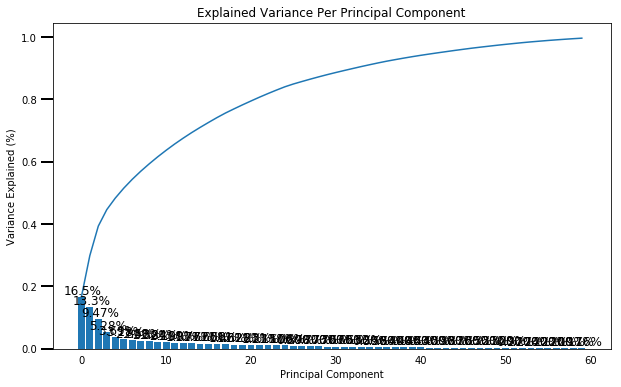

In [9]:
scree_plot(pca)
sum(pca.explained_variance_ratio_)

In [10]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_25 = PCA(n_components=25)
final_pca = pca_25.fit_transform(azdias_features)


In [11]:
sum(pca_25.explained_variance_ratio_)

0.84036097798529197

### Discussion 2.2: Perform Dimensionality Reduction

The principal component analysis was used to perform the dimenstionality reduction. This is done to reduce the number of features but keep maximum variability as much as possible. At first the PCA was fit with all of the features present in the dataset and then the scree-plot was plotted to find the best number of features which explains most of the variance. Looking at the scree-plot, I decided to used 25 components, which would explain around 84% of the variability in the dataset. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [12]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_results(full_dataset, pca, component):

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    all =  pd.concat([variance_ratios, components], axis = 1)
    return all.iloc[(component -1),1:]



In [13]:
first_pc = pca_results(azdias_lte20, pca_25,1)
first_pc.sort_values(ascending=False, inplace=True)
first_pc

PLZ8_ANTG3               0.2253
PLZ8_ANTG4               0.2169
WEALTH                   0.2047
HH_EINKOMMEN_SCORE       0.2023
ORTSGR_KLS9              0.1968
EWDICHTE                 0.1947
FINANZ_HAUSBAUER         0.1596
KBA05_ANTG4              0.1540
PLZ8_ANTG2               0.1537
FINANZ_SPARER            0.1530
ARBEIT                   0.1426
KBA05_ANTG3              0.1367
ANZ_HAUSHALTE_AKTIV      0.1361
RELAT_AB                 0.1350
SEMIO_PFLICHT            0.1211
SEMIO_REL                0.1185
DECADE                   0.1122
MOVEMENT                 0.1102
SEMIO_RAT                0.0995
SEMIO_TRADV              0.0936
SEMIO_MAT                0.0824
SEMIO_FAM                0.0810
FINANZ_UNAUFFAELLIGER    0.0810
SEMIO_KULT               0.0755
FINANZ_ANLEGER           0.0750
REGIOTYP                 0.0603
SEMIO_SOZ                0.0433
PLZ8_HHZ                 0.0423
HEALTH_TYP               0.0412
KKK                      0.0396
                          ...  
SEMIO_DO

In [14]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_pc = pca_results(azdias_lte20, pca_25,2)
second_pc.sort_values(ascending=False, inplace=True)
second_pc

ALTERSKATEGORIE_GROB     0.2563
SEMIO_ERL                0.2299
FINANZ_VORSORGER         0.2293
SEMIO_LUST               0.1802
RETOURTYP_BK_S           0.1620
FINANZ_HAUSBAUER         0.1217
SEMIO_KRIT               0.1180
SEMIO_KAEM               0.1164
W_KEIT_KIND_HH           0.1148
PLZ8_ANTG3               0.0983
EWDICHTE                 0.0978
ORTSGR_KLS9              0.0965
PLZ8_ANTG4               0.0961
ANREDE_KZ                0.0932
WEALTH                   0.0792
KBA05_ANTG4              0.0751
SEMIO_DOM                0.0745
ARBEIT                   0.0717
RELAT_AB                 0.0692
PLZ8_ANTG2               0.0681
ANZ_HAUSHALTE_AKTIV      0.0664
HH_EINKOMMEN_SCORE       0.0618
FINANZ_MINIMALIST        0.0594
WOHNDAUER_2008           0.0584
KBA05_ANTG3              0.0505
VERS_TYP                 0.0322
ANZ_HH_TITEL             0.0321
MOVEMENT                 0.0184
PLZ8_HHZ                 0.0158
REGIOTYP                 0.0119
                          ...  
SOHO_KZ 

In [15]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pc = pca_results(azdias_lte20, pca_25,3)
third_pc.sort_values(ascending=False, inplace=True)
third_pc


SEMIO_VERT               0.3447
SEMIO_SOZ                0.2619
SEMIO_FAM                0.2489
SEMIO_KULT               0.2338
FINANZ_MINIMALIST        0.1545
RETOURTYP_BK_S           0.1091
FINANZ_VORSORGER         0.1018
W_KEIT_KIND_HH           0.0852
ALTERSKATEGORIE_GROB     0.0798
SEMIO_REL                0.0678
SEMIO_LUST               0.0646
SEMIO_MAT                0.0556
ORTSGR_KLS9              0.0503
EWDICHTE                 0.0495
PLZ8_ANTG4               0.0491
PLZ8_ANTG3               0.0484
GREEN_AVANTGARDE         0.0471
ARBEIT                   0.0373
RELAT_AB                 0.0343
PLZ8_ANTG2               0.0327
WOHNDAUER_2008           0.0326
WEALTH                   0.0302
KBA05_ANTG4              0.0299
ANZ_HAUSHALTE_AKTIV      0.0268
ANZ_HH_TITEL             0.0139
KBA05_ANTG3              0.0118
ANZ_TITEL                0.0097
PLZ8_HHZ                 0.0056
VERS_TYP                 0.0019
SOHO_KZ                  0.0002
                          ...  
KKK     

### Discussion 2.3: Interpret Principal Components

First Principal Component : The first principal component has a strong positive relationship with PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region) and PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region) and a strong negative relationship with MOBI_REGIO(Movement patterns) and PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region). The larger value of PC1 is highly related to larger values in PLZ8_ANTG3(Number of 6-10 family houses in the PLZ8 region) and PLZ8_ANTG4(Number of 10+ family houses in the PLZ8 region); the smaller value of PC1 is related with larger value in MOBI_REGIO(Movement patterns) and PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region).

Second Principal Component : The first principal component has a strong positive relationship with ALTERSKATEGORIE_GROB(Estimated age based on given name analysis) and SEMIO_ERL(event-oriented) and a strong negative realtionship with DECADE and SEMIO_REL(religious). 

Third Principal Component : The first principal component has a strong positive relationship with SEMIO_VERT(dreamful) and SEMIO_SOZ(socially-minded) and a strong negative realtionship with SEMIO_KAEM(combative attitude) and ANREDE_KZ(Gender). 



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [72]:
def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

# Over a number of different cluster counts...
scores = []
centers = list(range(1,16))

# run k-means clustering on the data and...
# compute the average within-cluster distances.
for center in centers:
    print(center)
    scores.append(get_kmeans_score(final_pca, center))
    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


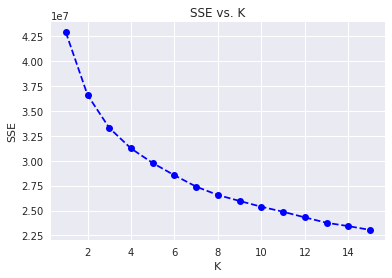

In [73]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [16]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 12)
model_12 = kmeans.fit(final_pca)
azdias_pred = model_12.predict(final_pca)

### Discussion 3.1: Apply Clustering to General Population

After the pre-processing and scaling of the data, the principal component analysis was performed and then the results were used to generate the clusters. Different numbers of clusters were tested from 1 through 15, after that, the within-cluster distance across the number of clusters were plotted to determine which numbers of clusters were appropriate. The SSE didn't decrease a lot more after k = 12, hence I decided to use 12 clusters.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [17]:
# Load in the customer demographics data.
customers = pd.read_csv ('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.describe()

In [18]:
# Get clean data
customers_clean = clean_data(customers)



(141640, 64)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,94914.000000,191412.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141153.000000,141176.000000,141153.000000
mean,1.665761,3.053461,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.823844,5.119517,2.897515
std,0.636370,1.066370,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.009424,2.159184,1.420665
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,2.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [21]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Impute nans
customers_features = pd.DataFrame(imputer.transform(customers_clean))
customers_features.columns=customers_clean.columns

# feature transformation
customers_scaled = pd.DataFrame(scaler.transform(customers_features))
customers_pca = pca_25.transform(customers_scaled)

# cluster prediction
customer_pred = model_12.predict(customers_pca)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

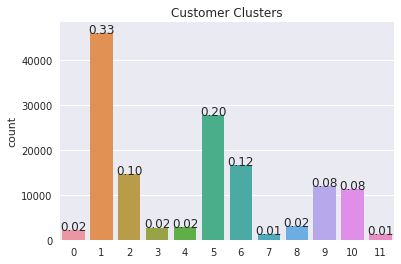

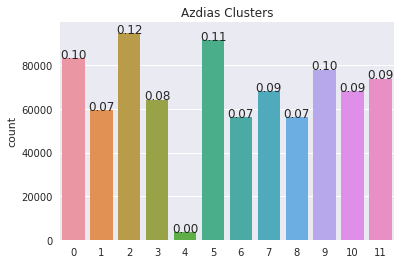

In [22]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


from matplotlib.pyplot import show


sns.set(style="darkgrid")
total = len(customer_pred)
ax1 = sns.countplot(customer_pred)
ax1.set_title('Customer Clusters') 
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
show()

total2 = len(azdias_pred)
ax2 = sns.countplot(azdias_pred)
ax2.set_title('Azdias Clusters') 
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total2),
            ha="center") 


In [23]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_1 = scaler.inverse_transform(pca_25.inverse_transform(model_12.cluster_centers_[1]))
over_df = pd.DataFrame(centroid_1, customers_clean.columns)

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(over_df)


                                 0
ALTERSKATEGORIE_GROB      3.265663
ANREDE_KZ                 1.070045
FINANZ_MINIMALIST         4.781347
FINANZ_SPARER             1.655745
FINANZ_VORSORGER          4.180511
FINANZ_ANLEGER            1.533269
FINANZ_UNAUFFAELLIGER     2.199662
FINANZ_HAUSBAUER          1.941321
GREEN_AVANTGARDE          0.982607
HEALTH_TYP                2.104510
RETOURTYP_BK_S            4.020672
SEMIO_SOZ                 5.309762
SEMIO_FAM                 4.850557
SEMIO_REL                 3.746158
SEMIO_MAT                 3.824742
SEMIO_VERT                6.212104
SEMIO_LUST                5.318920
SEMIO_ERL                 4.131085
SEMIO_KULT                4.852136
SEMIO_RAT                 2.688754
SEMIO_KRIT                3.233125
SEMIO_DOM                 3.343457
SEMIO_KAEM                2.712261
SEMIO_PFLICHT             3.304031
SEMIO_TRADV               3.125743
SOHO_KZ                   0.008362
VERS_TYP                  1.504518
ANZ_PERSONEN        

In [24]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_7 = scaler.inverse_transform(pca_25.inverse_transform(model_12.cluster_centers_[7]))
under_df = pd.DataFrame(centroid_7, customers_clean.columns)

with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(under_df)

                                 0
ALTERSKATEGORIE_GROB      1.929574
ANREDE_KZ                 0.969806
FINANZ_MINIMALIST         1.911174
FINANZ_SPARER             4.343324
FINANZ_VORSORGER          2.113174
FINANZ_ANLEGER            3.544945
FINANZ_UNAUFFAELLIGER     3.735577
FINANZ_HAUSBAUER          3.574703
GREEN_AVANTGARDE          0.120504
HEALTH_TYP                2.403844
RETOURTYP_BK_S            2.846040
SEMIO_SOZ                 6.347354
SEMIO_FAM                 6.641860
SEMIO_REL                 6.179495
SEMIO_MAT                 5.086807
SEMIO_VERT                5.975931
SEMIO_LUST                3.096087
SEMIO_ERL                 2.321255
SEMIO_KULT                6.770285
SEMIO_RAT                 4.042872
SEMIO_KRIT                2.839331
SEMIO_DOM                 2.921278
SEMIO_KAEM                2.499840
SEMIO_PFLICHT             5.504096
SEMIO_TRADV               4.717142
SOHO_KZ                   0.008067
VERS_TYP                  1.568454
ANZ_PERSONEN        

### Discussion 3.3: Compare Customer Data to Demographics Data

From the plots that were created above, we can see that cluster 7 is one of the under-represented clusters in the customer data whereas cluster 1 is one of the over-represented clusters in the customer data when compared to the general population.

Some of the characteristics in the over-represented cluster (cluster 1) include prosperous households (WEALTH), upper middle class/middle class (REGIO_TYP), high or very high income (HH_EINKOMMEN_SCORE), 46-60 years old (ALTERSKATEGORIE_GROB), families with school age children or older families and mature couples (LIFESTAGE), conservative low-returner (RETOURTYP_BK_S), high or very high money saver (FINANZ_SPARER), average or high number of 1-2 family houses (KBA05_ANTG1), and 20K-50K inhabitants in community (ORTSGR_KLS9). 

Some of the characteristics in the under-represented cluster (cluster 7) include less affluent or poor households, lower middle class, lower or very low income, 30-45 years old, young couples with children, incentive-receptive normal returner, low or very low money saver, none or lower share of the number of 1-2 family houses, and 100K-300K inhabitants in community.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.